In [39]:
from DS_WCS_projections import *
from DS_data_transformation import *
import DS_Coma_Cluster_param as cc_prm
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
y = None

In [9]:
with fits.open('/home/rt2122/Data/Planck/y/nilc_ymaps.fits') as hdul:
    print(repr(hdul[1].header))
    print(hdul[1].columns)
    y = np.array(hdul[1].data['FULL'])

XTENSION= 'BINTABLE'           /Written by IDL:  Sun Feb  1 15:05:26 2015       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   16 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    4 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2015-02-01'      

In [10]:
pic = np.zeros((2048, 2048))

In [11]:
wcs = custom_wcs(cc_prm.ra_center, cc_prm.dec_center)

/home/rt2122/L/git/data-segmentation-2/modules/DS_WCS_projections.py:39: RuntimeWarning: cdelt will be ignored since cd is present
  w1.wcs.cdelt = w.wcs.cdelt[:2]


In [15]:
for i in tqdm(range(pic.shape[0])):
    coords = wcs.all_pix2world(np.full(2048, i), np.arange(2048), 0)
    sc = SkyCoord(ra=coords[0]*u.degree, dec=coords[1]*u.degree, frame='icrs')
    theta = sc.galactic.l.degree
    phi = sc.galactic.b.degree
    ipix = hp.ang2pix(nside=2048, theta=theta, phi=phi, lonlat=True, nest=False) 
    
    pic[i] = y[ipix]

In [18]:
npic = np.copy(pic)

In [19]:
npic -= np.mean(npic.flatten())
npic /= np.std(npic.flatten())

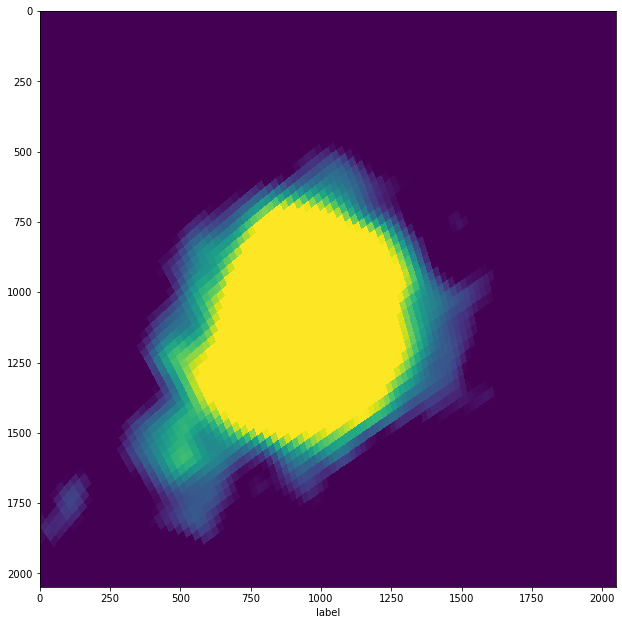

In [20]:
show_pic(npic)

In [22]:
df = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_filtered.csv')

In [23]:
df = n_max_flux_df(df, 100, ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

In [24]:
df.to_csv('/home/rt2122/Data/coma_sweep/south/100max.csv', index=False)

In [25]:
pixels = wcs.all_world2pix(np.array(df['RA']), np.array(df['DEC']), 0)
pixels = np.array(pixels, dtype=np.int32).T

In [26]:
circles = draw_circles(pixels, df['FLUX_G'] + df['FLUX_R'] + df['FLUX_Z'], 
                       (2048, 2048), 0.02)

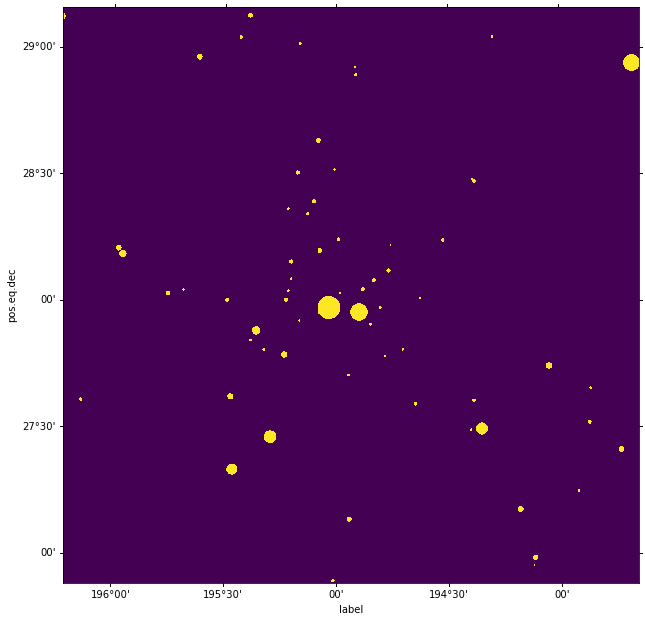

In [29]:
show_pic(np.flipud(np.rot90(circles)), projection=wcs)

In [30]:
pic = pic.reshape((2048, 2048, 1))
circles = circles.reshape((2048, 2048, 1))

In [36]:
all_pic = np.flipud(np.rot90(np.dstack([npic, circles, circles])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


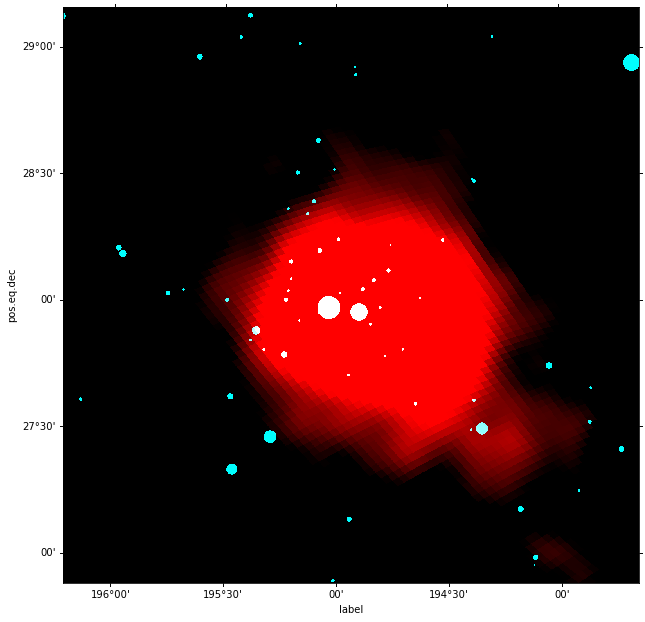

In [38]:
show_pic(all_pic, projection=wcs)

In [40]:
x = np.arange(2048)
y = np.arange(2048)
X, Y = np.meshgrid(x, y)

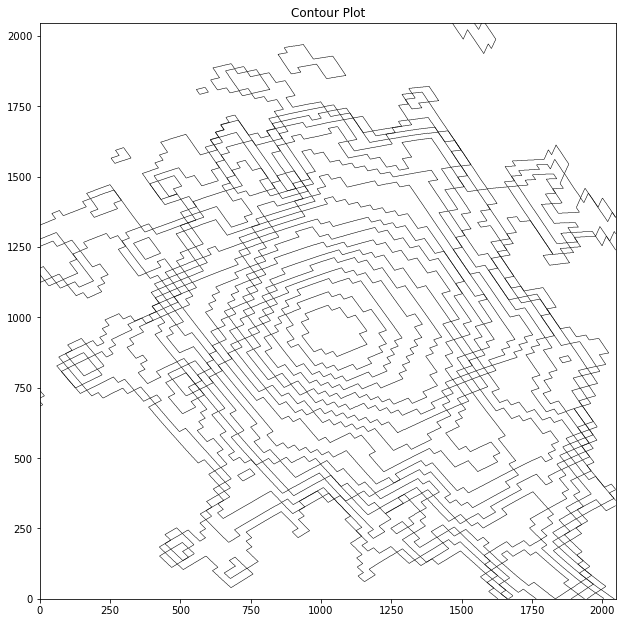

In [87]:
fig = plt.figure(figsize=(10,10))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = ax.contour(X, Y, np.flipud(np.rot90(pic[:,:,0])), levels=levels, linewidths=0.5,
               colors='k')
#ax.clabel(cp)
ax.set_title('Contour Plot')
#ax.set_xlabel('x (cm)')
#ax.set_ylabel('y (cm)')
plt.show()

In [86]:
levels = np.array([pic[1024, 1024, 0] / 16 * ((2 ** (1/4)) ** k) for k in range(100)])

In [58]:
pic[1024, 1024, 0]

5.6929278798634186e-05